In [1]:
import kagglehub
dataset_path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/brats20-dataset-training-validation


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import time
import gc

import nibabel as nib

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

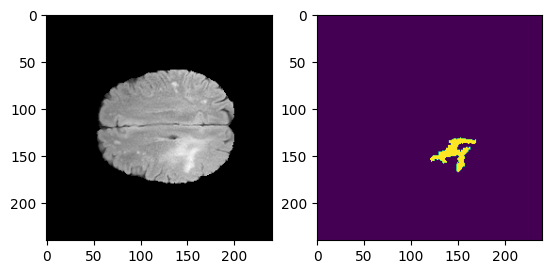

In [3]:
base_path = dataset_path +'/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patient_id = 'BraTS20_Training_003'

Flair1 = nib.load(f'{base_path}/{patient_id}/{patient_id}_flair.nii')
Seg1 = nib.load(f'{base_path}/{patient_id}/{patient_id}_seg.nii')

fig, ax = plt.subplots(1,2)
num = 100
a = Flair1.get_fdata()[:, :, num]
ax[0].imshow(a, cmap='gray')
a = Seg1.get_fdata()[:, :, num]
ax[1].imshow(a)

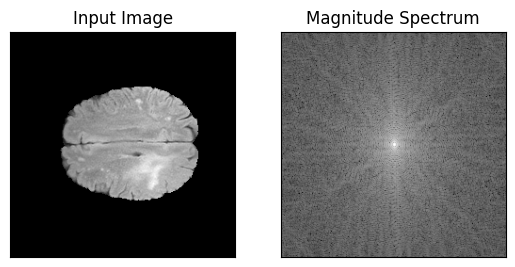

In [4]:
f = np.fft.fft2(Flair1.get_fdata()[:,:,100])
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121), plt.imshow(Flair1.get_fdata()[:,:,100], cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

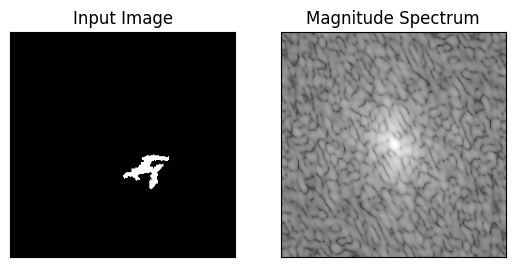

In [5]:
f = np.fft.fft2(Seg1.get_fdata()[:,:,100]>1)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121), plt.imshow(Seg1.get_fdata()[:,:,100], cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

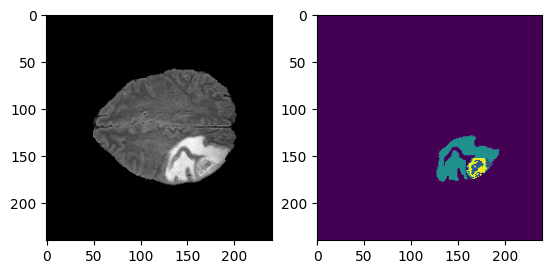

In [6]:
base_path = dataset_path +'/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patient_id = 'BraTS20_Training_004'

Flair2 = nib.load(f'{base_path}/{patient_id}/{patient_id}_flair.nii')
Seg2 = nib.load(f'{base_path}/{patient_id}/{patient_id}_seg.nii')
fig, ax = plt.subplots(1,2)

a = Flair2.get_fdata()[:, :, 100]
ax[0].imshow(a, cmap='gray')
a = Seg2.get_fdata()[:, :, 100]
ax[1].imshow(a)

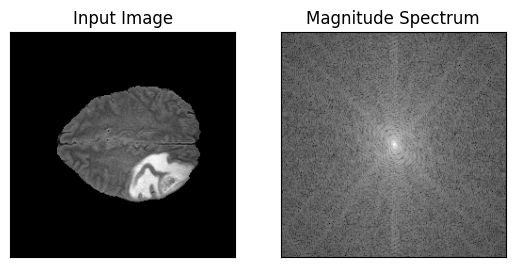

In [7]:
f = np.fft.fft2(Flair2.get_fdata()[:,:,100])
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121), plt.imshow(Flair2.get_fdata()[:,:,100], cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

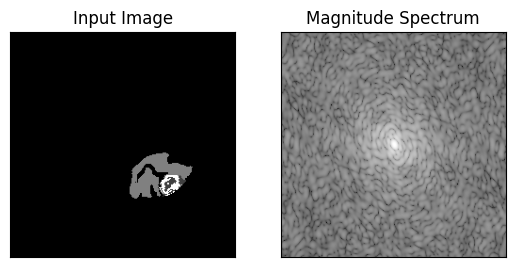

In [8]:
f = np.fft.fft2(Seg2.get_fdata()[:,:,100]>1)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121), plt.imshow(Seg2.get_fdata()[:,:,100], cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
a = nn.Conv2d(10, 10, 2)
torch.save(a.state_dict(), f"del.pth")

In [11]:
class UNet_Big(nn.Module):
    def __init__(self):
        super(UNet_Big, self).__init__()

        self.conv1_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2_1 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3_1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    
        self.up4 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.conv4_1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)

        self.up5 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)
        self.conv5_1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(16, 4, kernel_size=3, padding=1)

    def forward(self, x):
        encoder1_1 = torch.relu(self.conv1_1(x))
        encoder1_2 = torch.relu(self.conv1_2(encoder1_1))
        encoder1_pool = self.pool1(encoder1_2)

        encoder2_1 = torch.relu(self.conv2_1(encoder1_pool))
        encoder2_2 = torch.relu(self.conv2_2(encoder2_1))
        encoder2_pool = self.pool2(encoder2_2)

        bottleneck_1 = torch.relu(self.conv3_1(encoder2_pool))
        bottleneck_2 = torch.relu(self.conv3_2(bottleneck_1))

        decode2_up = self.up4(bottleneck_2)
        decode2_concat = torch.cat([decode2_up, encoder2_2], dim=1)
        decode2_1 = torch.relu(self.conv4_1(decode2_concat))
        decode2_2 = torch.relu(self.conv4_2(decode2_1))

        decode1_up = self.up5(decode2_2)
        decode1_concat = torch.cat([decode1_up, encoder1_2], dim=1)
        decode1_2 = torch.relu(self.conv5_1(decode1_concat))
        decode1_3 = self.conv5_2(decode1_2)

        return decode1_3

# Instantiate the model
model = UNet_Big()

# Print model summary
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

UNet_Big(
  (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up4): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv4_1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up5): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv5_1): Conv2d(32, 16, kernel_size=(3, 3), str

In [15]:
model = UNet_Big()

model.load_state_dict(torch.load('/kaggle/input/tmp/pytorch/default/1/UNet2_weights_0.pth'))

/tmp/ipykernel_30/567532179.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/tmp/pytorch/default/1/UNet2_weights_0.pth'))


<All keys matched successfully>